In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from impedance import preprocessing
from impedance.validation import linKK
from impedance.visualization import plot_nyquist, plot_residuals
import os
import re

## Fit equivalent circuit model to the aging data

In [2]:
data_files = os.listdir('impedance csvs/DensoData_EIS')

In [3]:
from impedance.models.circuits import CustomCircuit

### Fit to one cell and visualize fit

In [4]:
circuit_def= 'L0-R0-p(R1,C1)-p(R2,C2)-Wo2-C3'
initial_guess = [1e-7, 1e-3, 1e-3, 10, 1e-3, 1, 1e-2, 1e4, 1e5]

circuit = CustomCircuit(circuit_def, initial_guess=initial_guess)

In [5]:
f, Z = preprocessing.readCSV('impedance csvs/DensoData_EIS/seriesIdx1t0N1T-10soc50_1.csv')
mask = f < 3.5e4
f = f[mask]
Z = Z[mask]

In [6]:
circuit.fit(f, Z)

c:\Users\pgasper\AppData\Local\Continuum\anaconda3\lib\site-packages\impedance\models\circuits\elements.py:143: RuntimeWarning: overflow encountered in tanh
  Z = Z0/(np.sqrt(1j*omega*tau)*np.tanh(np.sqrt(1j*omega*tau)))


In [7]:
print(circuit)


Circuit string: L0-R0-p(R1,C1)-p(R2,C2)-Wo2
Fit: True

Initial guesses:
     L0 = 1.00e-07 [H]
     R0 = 1.00e-03 [Ohm]
     R1 = 1.00e-03 [Ohm]
     C1 = 1.00e+01 [F]
     R2 = 1.00e-03 [Ohm]
     C2 = 1.00e+00 [F]
  Wo2_0 = 1.00e-02 [Ohm]
  Wo2_1 = 1.00e+04 [sec]

Fit parameters:
     L0 = 7.09e-08  (+/- 3.68e-10) [H]
     R0 = 1.10e-03  (+/- 2.32e-05) [Ohm]
     R1 = 3.21e-03  (+/- 9.28e-05) [Ohm]
     C1 = 1.26e+01  (+/- 8.52e-01) [F]
     R2 = 1.43e-03  (+/- 9.31e-05) [Ohm]
     C2 = 3.09e+00  (+/- 2.07e-01) [F]
  Wo2_0 = 3.27e-02  (+/- 1.25e-03) [Ohm]
  Wo2_1 = 1.12e+04  (+/- 1.82e-09) [sec]



In [9]:
Z_fit = circuit.predict(f)

c:\Users\pgasper\AppData\Local\Continuum\anaconda3\lib\site-packages\impedance\models\circuits\elements.py:143: RuntimeWarning: overflow encountered in tanh
  Z = Z0/(np.sqrt(1j*omega*tau)*np.tanh(np.sqrt(1j*omega*tau)))


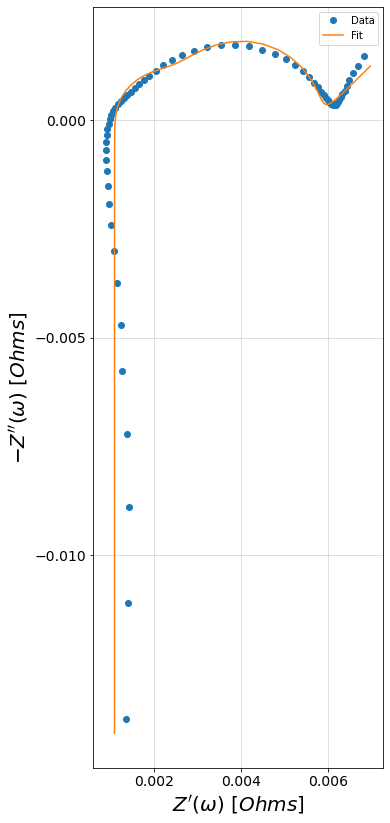

c:\Users\pgasper\AppData\Local\Continuum\anaconda3\lib\site-packages\impedance\visualization.py:98: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax_mag.plot(f, np.abs(Z), fmt, **kwargs)
c:\Users\pgasper\AppData\Local\Continuum\anaconda3\lib\site-packages\impedance\visualization.py:98: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  ax_mag.plot(f, np.abs(Z), fmt, **kwargs)
c:\Users\pgasper\AppData\Local\Continuum\anaconda3\lib\site-packages\impedance\visualization.py:99: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  ax_phs.plot(f, -np.angle(Z, deg=True), fmt, **kwargs)
c:\Users\pgasper\AppData\Local\Continuum\anaconda3\lib\site-

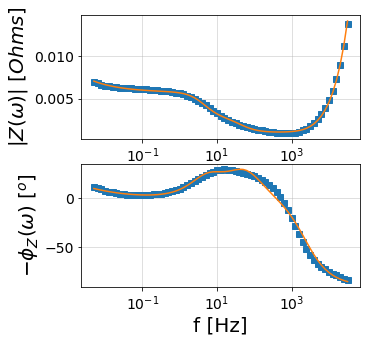

In [10]:
fig, ax = plt.subplots(figsize=(10,14))
plot_nyquist(ax, Z, fmt='o')
plot_nyquist(ax, Z_fit, fmt='-')

plt.legend(['Data', 'Fit'])
plt.show()

circuit.plot(f_data=f, Z_data=Z, kind='bode')
plt.show()

In [11]:
res_meas_real = (Z - circuit.predict(f)).real/np.abs(Z)
res_meas_imag = (Z - circuit.predict(f)).imag/np.abs(Z)

c:\Users\pgasper\AppData\Local\Continuum\anaconda3\lib\site-packages\impedance\models\circuits\elements.py:143: RuntimeWarning: overflow encountered in tanh
  Z = Z0/(np.sqrt(1j*omega*tau)*np.tanh(np.sqrt(1j*omega*tau)))


<AxesSubplot:xlabel='$f$ [Hz]', ylabel='$\\Delta$ $(\\%)$'>

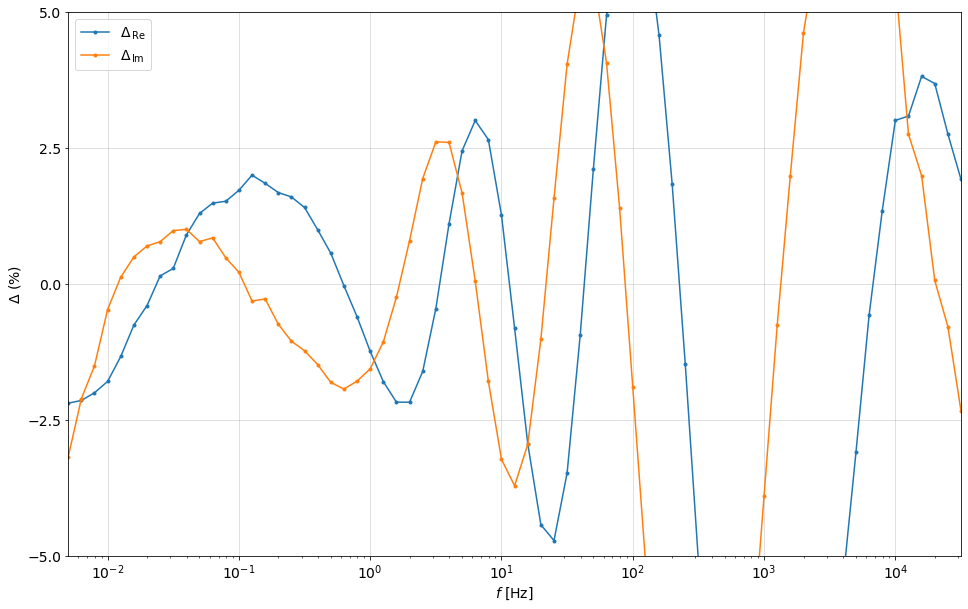

In [12]:
fig, ax = plt.subplots(figsize=(16,10))
plot_residuals(ax, f, res_meas_real, res_meas_imag)

### Fit to all cells and visualize parameter and error distribution

In [12]:
params = pd.DataFrame(columns = ['L0', 'R0', 'R1', 'C1', 'R2', 'C2', 'Wo2_0', 'Wo2_1', 'C3'])
circuit_def= 'L0-R0-p(R1,C1)-p(R2,C2)-Wo2-C3'
initial_guess = [1e-7, 1e-3, 1e-3, 10, 1e-3, 1, 1e-2, 1e4, 1e5]

T = []
Zs = []
Z_fits = []
SSE_real = []
SSE_imag = []
MSE_real = []
MSE_imag = []
res_real = []
res_imag = []
frequency = []

In [13]:
data_files = os.listdir('impedance csvs/DensoData_EIS')

In [14]:
 for data_file in data_files:
    T = T + [int(re.search('T(.*?)s', data_file).group(1))]
    frequencies, Z = preprocessing.readCSV('impedance csvs/DensoData_EIS/' + data_file)
    Zs = Zs +[Z]
    frequency = frequency + [frequencies]
    circuit = CustomCircuit(circuit_def, initial_guess=initial_guess)
    circuit.fit(frequencies, Z)
    Z_fit = circuit.predict(frequencies)
    Z_fits = Z_fits + [Z_fit]
    res_real = res_real + [(Z - Z_fit).real/np.abs(Z)]
    res_imag = res_imag + [(Z - Z_fit).imag/np.abs(Z)]

    SSE_real = SSE_real + [sum((Z.real-Z_fit.real)**2)**0.5]
    SSE_imag = SSE_imag + [sum((Z.imag-Z_fit.imag)**2)**0.5]
    MSE_real = MSE_real + [sum((Z.real-Z_fit.real)**2)/len(Z.real)]
    MSE_imag = MSE_imag + [sum((Z.imag-Z_fit.imag)**2)/len(Z.imag)]
    parameters = pd.DataFrame(circuit.parameters_.reshape(1,9), columns=params.columns)
    params = params.append(parameters, ignore_index=True)

C:\Users\pgasper\AppData\Local\Continuum\anaconda3\lib\site-packages\impedance\models\circuits\elements.py:143: RuntimeWarning: overflow encountered in tanh
  Z = Z0/(np.sqrt(1j*omega*tau)*np.tanh(np.sqrt(1j*omega*tau)))


In [15]:
params.to_csv('DensoData_EIS_parameters.csv', index=False)

In [17]:
params['T'] = T
params['Z'] = Zs
params['SSE_real'] = SSE_real
params['SSE_imag'] = SSE_imag
params['MSE_real'] = MSE_real
params['MSE_imag'] = MSE_imag

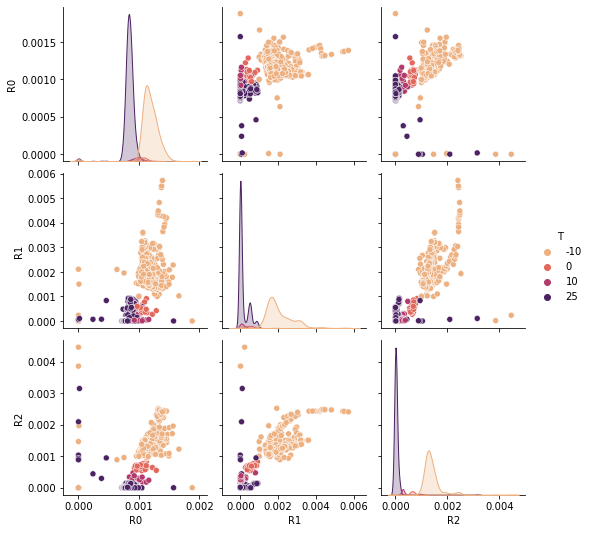

In [19]:
params2 = params[['R0', 'R1', 'R2', 'T']]

import seaborn as sns
sns.pairplot(params2, hue = "T", palette="flare")

## Separate nyquist plot for visualizing the ECM fit

In [45]:
f, Z = preprocessing.readCSV('impedance csvs/DensoData_EIS/seriesIdx18t356N1650T25soc50_658.csv')
mask = f<=5e2
Z = Z[mask]
f=f[mask]
mask =  f>=9e-3
Z =Z[mask]
f=f[mask]
circuit = CustomCircuit(circuit_def, initial_guess=initial_guess)
circuit.fit(f, Z)
Z_fit = circuit.predict(f)

In [46]:
# Circuit model for plotting elements separately
circuit_string_RC = 'R0-p(R1,C1)'
circuit_string_L = 'R0-L1'
circuit_string_diff = 'R0-Wo1-C2'

In [47]:
 # Calculate the impedance of each individual R,CPE pair
p = circuit.parameters_
params_L = p[1], p[0]
circuit_L = CustomCircuit(circuit_string_L, initial_guess=params_L)
Z_L = circuit_L.predict(f)
params_RC1 = p[1], p[4], p[5] 
circuit_RC1 = CustomCircuit(circuit_string_RC, initial_guess=params_RC1)
Z_RC1 = circuit_RC1.predict(f)
params_RC2 = p[1]+p[4], p[2], p[3]
circuit_RC2 = CustomCircuit(circuit_string_RC, initial_guess=params_RC2)
Z_RC2 = circuit_RC2.predict(f)
params_diff = p[1]+p[2]+p[4], p[6], p[7], p[8]
circuit_diff = CustomCircuit(circuit_string_diff, initial_guess=params_diff)
Z_diff = circuit_diff.predict(f)

Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
Simulating circuit based on initial parameters


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


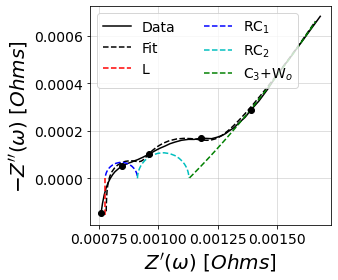

In [50]:
# Plot data, fit
# Nyquist
fig, ax = plt.subplots(figsize=(6,4))
plot_nyquist(ax, Z, fmt='-k')
plot_nyquist(ax, Z_fit, fmt='--k')
plot_nyquist(ax, Z_L, fmt='--r')
plot_nyquist(ax, Z_RC1, fmt='--b')
plot_nyquist(ax, Z_RC2, fmt='--c')
plot_nyquist(ax, Z_diff, fmt='--g', units='\Omega*g_{Active}')
ax.legend(['Data','Fit','L','RC$_1$','RC$_2$', 'C$_3$+W$_o$'], fontsize=14, ncol=2)
# Plot markers at frequency decades
ind_f_decades = range(0,len(f),10)
plot_nyquist(ax, Z[ind_f_decades], fmt='ok')

plt.tight_layout()
fig.savefig('example nyquist.eps', dpi=300)
fig.savefig('example nyquist.jpg', dpi=300)
fig.savefig('example nyquist.tif', dpi=300)

## Fit Second Data Table

In [24]:
params2 = pd.DataFrame(columns = ['L0', 'R0', 'R1', 'C1', 'R2', 'C2', 'Wo2_0', 'Wo2_1', 'C3'])
circuit_def= 'L0-R0-p(R1,C1)-p(R2,C2)-Wo2-C3'
initial_guess = [1e-7, 1e-3, 1e-3, 10, 1e-3, 1, 1e-2, 1e4, 1e5]

T = []
Zs = []
Z_fits = []
SSE_real = []
SSE_imag = []
MSE_real = []
MSE_imag = []
res_real = []
res_imag = []
frequency = []

In [25]:
data_files = os.listdir('impedance csvs/DensoData_EIS_vSOCvT')

In [26]:
for data_file in data_files:
    T = T + [int(re.search('T(.*?)s', data_file).group(1))]
    frequencies, Z = preprocessing.readCSV('impedance csvs/DensoData_EIS_vSOCvT/' + data_file)
    Zs = Zs +[Z]
    frequency = frequency + [frequencies]
    circuit = CustomCircuit(circuit_def, initial_guess=initial_guess)
    circuit.fit(frequencies, Z)
    Z_fit = circuit.predict(frequencies)
    Z_fits = Z_fits + [Z_fit]
    res_real = res_real + [(Z - Z_fit).real/np.abs(Z)]
    res_imag = res_imag + [(Z - Z_fit).imag/np.abs(Z)]

    SSE_real = SSE_real + [sum((Z.real-Z_fit.real)**2)**0.5]
    SSE_imag = SSE_imag + [sum((Z.imag-Z_fit.imag)**2)**0.5]
    MSE_real = MSE_real + [sum((Z.real-Z_fit.real)**2)/len(Z.real)]
    MSE_imag = MSE_imag + [sum((Z.imag-Z_fit.imag)**2)/len(Z.imag)]
    parameters = pd.DataFrame(circuit.parameters_.reshape(1,9), columns=params2.columns)
    params2 = params2.append(parameters, ignore_index=True)

C:\Users\pgasper\AppData\Local\Continuum\anaconda3\lib\site-packages\impedance\models\circuits\elements.py:143: RuntimeWarning: overflow encountered in tanh
  Z = Z0/(np.sqrt(1j*omega*tau)*np.tanh(np.sqrt(1j*omega*tau)))


In [27]:
params2.to_csv('DensoData_EIS_vSOCvT_parameters.csv', index=False)

In [28]:
params2['T'] = T
params2['Z'] = Zs
params2['SSE_real'] = SSE_real
params2['SSE_imag'] = SSE_imag
params2['MSE_real'] = MSE_real
params2['MSE_imag'] = MSE_imag

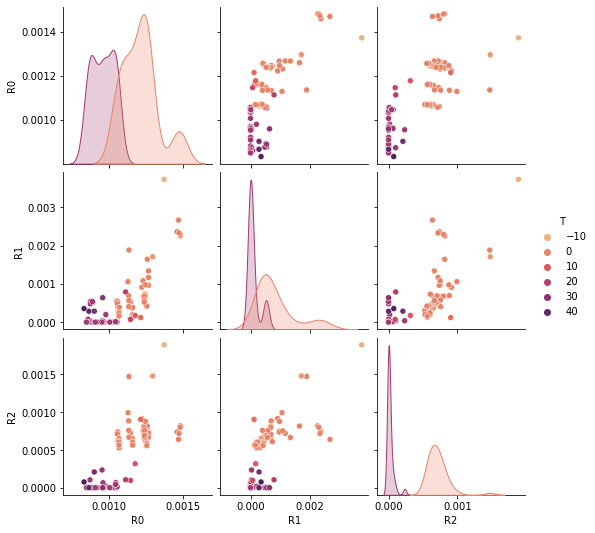

In [29]:
import warnings
warnings.filterwarnings("ignore")

params2b = params2[['R0', 'R1', 'R2', 'T']]
sns.pairplot(params2b, hue = "T", palette="flare")

In [51]:
f, Z = preprocessing.readCSV('impedance csvs/DensoData_EIS_vSOCvT/groupIdx37T0soc90_34.csv')
mask = f<=1e3
Z = Z[mask]
f=f[mask]
circuit = CustomCircuit(circuit_def, initial_guess=initial_guess)
circuit.fit(f, Z)
Z_fit = circuit.predict(f)

In [52]:
# Calculate the impedance of each individual R,CPE pair
p = circuit.parameters_
params_L = p[1], p[0]
circuit_L = CustomCircuit(circuit_string_L, initial_guess=params_L)
Z_L = circuit_L.predict(f)
params_RC1 = p[1]+p[4],p[2], p[3]
circuit_RC1 = CustomCircuit(circuit_string_RC, initial_guess=params_RC1)
Z_RC1 = circuit_RC1.predict(f)
params_RC2 = p[1], p[4], p[5]
circuit_RC2 = CustomCircuit(circuit_string_RC, initial_guess=params_RC2)
Z_RC2 = circuit_RC2.predict(f)
params_diff = p[1]+p[2]+p[4], p[6], p[7], p[8]
circuit_diff = CustomCircuit(circuit_string_diff, initial_guess=params_diff)
Z_diff = circuit_diff.predict(f)

Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
Simulating circuit based on initial parameters
Simulating circuit based on initial parameters


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


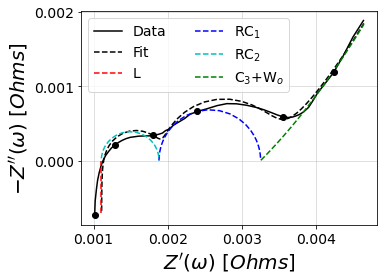

In [53]:
# Plot data, fit
# Nyquist
fig, ax = plt.subplots(figsize=(6,4))
plot_nyquist(ax, Z, fmt='-k')
plot_nyquist(ax, Z_fit, fmt='--k')
plot_nyquist(ax, Z_L, fmt='--r')
plot_nyquist(ax, Z_RC1, fmt='--b')
plot_nyquist(ax, Z_RC2, fmt='--c')
plot_nyquist(ax, Z_diff, fmt='--g', units='\Omega*g_{Active}')
ax.legend(['Data','Fit','L','RC$_1$','RC$_2$', 'C$_3$+W$_o$'], fontsize=14, ncol=2)
# Plot markers at frequency decades
ind_f_decades = range(0,len(f),10)
plot_nyquist(ax, Z[ind_f_decades], fmt='ok')

plt.tight_layout()
fig.savefig('example nyquist 2.eps', dpi=300)
fig.savefig('example nyquist 2.jpg', dpi=300)
fig.savefig('example nyquist 2.tif', dpi=300)